In [20]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [21]:
#load the date to a pandas dataframe
df=pd.read_csv("data/Bitstamp_BTCUSD_d.csv")
df.head()

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
0,1646611200,2022-03-07 00:00:00,BTC/USD,38404.97,38483.92,38021.39,38390.55,28.574703,1.096999e+06
1,1646524800,2022-03-06 00:00:00,BTC/USD,39390.31,39701.00,38100.00,38438.89,1194.373734,4.591040e+07
2,1646438400,2022-03-05 00:00:00,BTC/USD,39170.19,39620.30,38600.30,39416.79,806.911429,3.180586e+07
3,1646352000,2022-03-04 00:00:00,BTC/USD,42476.25,42540.57,38590.95,39175.56,2493.657430,9.769043e+07
4,1646265600,2022-03-03 00:00:00,BTC/USD,43936.73,44118.53,41832.34,42476.26,2253.430770,9.571731e+07


Text(0, 0.5, 'Preço')

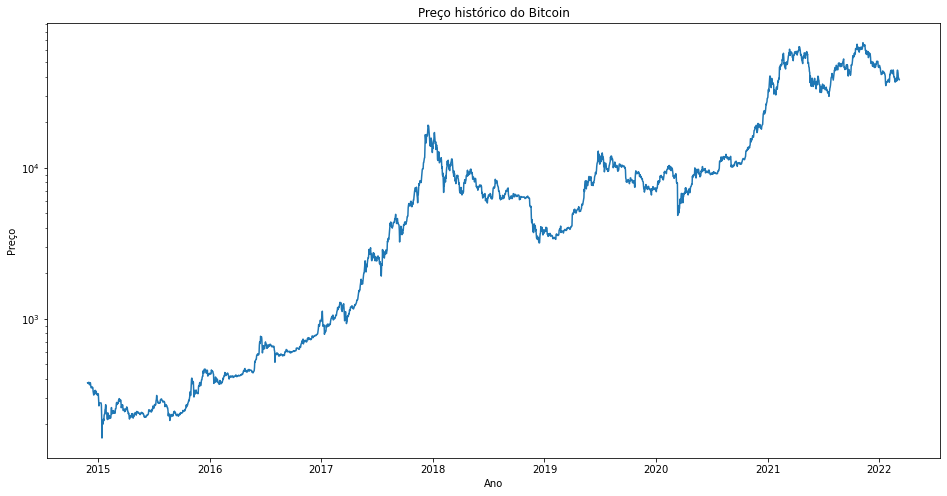

In [22]:
#format date column
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
#set date column as index
df.index=df['Date']
#plot figure
plt.figure(figsize=(16,8))
plt.plot(df["Close"])
plt.yscale("log")
plt.title("Preço histórico do Bitcoin")
plt.xlabel("Ano")
plt.ylabel("Preço")


In [23]:
#sort df ascending date
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

new_dataset

,Date,Close
0,2014-11-28 00:00:00,376.28
1,2014-11-29 00:00:00,376.72
2,2014-11-30 00:00:00,373.34
3,2014-12-01 00:00:00,378.39
4,2014-12-02 00:00:00,379.25
...,...,...
2652,2022-03-03 00:00:00,42476.26
2653,2022-03-04 00:00:00,39175.56
2654,2022-03-05 00:00:00,39416.79
2655,2022-03-06 00:00:00,38438.89


In [24]:
#get the close values as a vertical array
dataframe_close = new_dataset.Close.values
df =dataframe_close.reshape(-1,1)


In [25]:
#split the values in train and test
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8):])
dataset_test

array([[10534.31],
       [10233.42],
       [10744.02],
       [10689.81],
       [10729.09],
       [10780.66],
       [10689.48],
       [10836.42],
       [10778.22],
       [10622.71],
       [10578.54],
       [10553.66],
       [10669.63],
       [10795.0],
       [10606.33],
       [10669.14],
       [10925.2],
       [11052.0],
       [11301.2],
       [11372.93],
       [11535.98],
       [11427.98],
       [11428.84],
       [11511.11],
       [11321.86],
       [11365.8],
       [11519.97],
       [11764.14],
       [11921.11],
       [12802.67],
       [12983.26],
       [12941.59],
       [13122.73],
       [13039.09],
       [13066.73],
       [13647.9],
       [13274.73],
       [13468.44],
       [13562.13],
       [13816.08],
       [13762.0],
       [13563.72],
       [14041.58],
       [14160.59],
       [15605.04],
       [15598.09],
       [14838.97],
       [15489.15],
       [15332.04],
       [15313.65],
       [15707.89],
       [16300.0],
       [16335.58],
 

In [26]:
#normalize the data 
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.fit_transform(dataset_test)

In [27]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [28]:
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [29]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [30]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [31]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [32]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
model.fit(x_train, y_train, epochs=25, batch_size=32)
model.save('stock_prediction.h5')

Epoch 1/25
65/65 [==============================] - 12s 90ms/step - loss: 0.0087
Epoch 2/25
65/65 [==============================] - 6s 90ms/step - loss: 0.0025
Epoch 3/25
65/65 [==============================] - 6s 89ms/step - loss: 0.0022
Epoch 4/25
65/65 [==============================] - 6s 90ms/step - loss: 0.0021
Epoch 5/25
65/65 [==============================] - 6s 89ms/step - loss: 0.0022
Epoch 6/25
65/65 [==============================] - 6s 88ms/step - loss: 0.0020
Epoch 7/25
65/65 [==============================] - 6s 89ms/step - loss: 0.0018
Epoch 8/25
65/65 [==============================] - 6s 89ms/step - loss: 0.0016
Epoch 9/25
65/65 [==============================] - 6s 91ms/step - loss: 0.0014
Epoch 10/25
65/65 [==============================] - 6s 90ms/step - loss: 0.0016
Epoch 11/25
65/65 [==============================] - 6s 91ms/step - loss: 0.0015
Epoch 12/25
65/65 [==============================] - 6s 88ms/step - loss: 0.0014
Epoch 13/25
65/65 [=================

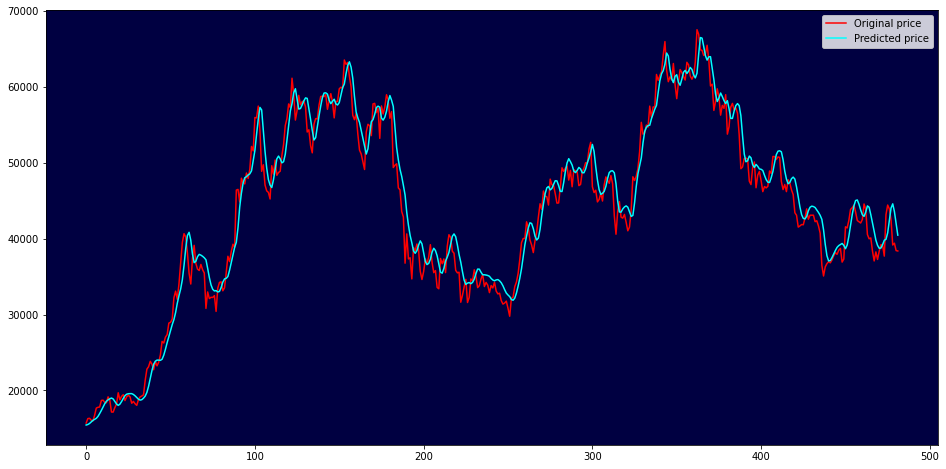

In [34]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.legend()

In [35]:

#dataset_train = np.array(df[:int(df.shape[0]*0.8)])
#dataset_test = np.array(df[int(df.shape[0]*0.8):])
df.shape[0]

2657